In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'deepsig_custom_v2_mp'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return modules, phases

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","([0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","([0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","([0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","([0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","([0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","([0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","([0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","([0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","([0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[module_phase_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.custom_deepsig_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
dense (Dense)                (None, 2, 256)            9472      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             18450     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4864  

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 30:25 - loss: 2.4008

 10/151 [>.............................] - ETA: 0s - loss: 2.3809   

 19/151 [==>...........................] - ETA: 0s - loss: 2.3544

 29/151 [====>.........................] - ETA: 0s - loss: 2.3318

 38/151 [======>.......................] - ETA: 0s - loss: 2.3155

 48/151 [========>.....................] - ETA: 0s - loss: 2.3001

 57/151 [==========>...................] - ETA: 0s - loss: 2.2877

 67/151 [============>.................] - ETA: 0s - loss: 2.2753

 77/151 [==============>...............] - ETA: 0s - loss: 2.2641

 87/151 [================>.............] - ETA: 0s - loss: 2.2537

 97/151 [==================>...........] - ETA: 0s - loss: 2.2440



107/151 [====================>.........] - ETA: 0s - loss: 2.2350

116/151 [======================>.......] - ETA: 0s - loss: 2.2275

126/151 [========================>.....] - ETA: 0s - loss: 2.2196

135/151 [=========================>....] - ETA: 0s - loss: 2.2130

144/151 [===========================>..] - ETA: 0s - loss: 2.2066

151/151 [==============================] - ETA: 0s - loss: 2.2019

151/151 [==============================] - 14s 10ms/step - loss: 2.2012 - val_loss: 1.9856


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 1.9814

 10/151 [>.............................] - ETA: 0s - loss: 1.9690

 19/151 [==>...........................] - ETA: 0s - loss: 1.9671

 29/151 [====>.........................] - ETA: 0s - loss: 1.9677

 39/151 [======>.......................] - ETA: 0s - loss: 1.9682

 49/151 [========>.....................] - ETA: 0s - loss: 1.9682

 59/151 [==========>...................] - ETA: 0s - loss: 1.9680

 69/151 [============>.................] - ETA: 0s - loss: 1.9676

 79/151 [==============>...............] - ETA: 0s - loss: 1.9672

 89/151 [================>.............] - ETA: 0s - loss: 1.9666

 99/151 [==================>...........] - ETA: 0s - loss: 1.9661

109/151 [====================>.........] - ETA: 0s - loss: 1.9654

118/151 [======================>.......] - ETA: 0s - loss: 1.9647

127/151 [========================>.....] - ETA: 0s - loss: 1.9641



137/151 [==========================>...] - ETA: 0s - loss: 1.9634

147/151 [============================>.] - ETA: 0s - loss: 1.9626

151/151 [==============================] - 1s 7ms/step - loss: 1.9623 - val_loss: 1.9451


Epoch 3/100
  1/151 [..............................] - ETA: 1s - loss: 1.8762

 10/151 [>.............................] - ETA: 0s - loss: 1.8957

 20/151 [==>...........................] - ETA: 0s - loss: 1.9034

 30/151 [====>.........................] - ETA: 0s - loss: 1.9071

 40/151 [======>.......................] - ETA: 0s - loss: 1.9092

 50/151 [========>.....................] - ETA: 0s - loss: 1.9103

 59/151 [==========>...................] - ETA: 0s - loss: 1.9113

 68/151 [============>.................] - ETA: 0s - loss: 1.9122

 78/151 [==============>...............] - ETA: 0s - loss: 1.9130

 88/151 [================>.............] - ETA: 0s - loss: 1.9134

 98/151 [==================>...........] - ETA: 0s - loss: 1.9138

108/151 [====================>.........] - ETA: 0s - loss: 1.9140

118/151 [======================>.......] - ETA: 0s - loss: 1.9141

128/151 [========================>.....] - ETA: 0s - loss: 1.9143

138/151 [==========================>...] - ETA: 0s - loss: 1.9144

148/151 [============================>.] - ETA: 0s - loss: 1.9144

151/151 [==============================] - 1s 7ms/step - loss: 1.9145 - val_loss: 1.9266


Epoch 4/100
  1/151 [..............................] - ETA: 1s - loss: 1.8974

 10/151 [>.............................] - ETA: 0s - loss: 1.8860

 20/151 [==>...........................] - ETA: 0s - loss: 1.8891

 29/151 [====>.........................] - ETA: 0s - loss: 1.8899

 39/151 [======>.......................] - ETA: 0s - loss: 1.8911



 49/151 [========>.....................] - ETA: 0s - loss: 1.8915

 59/151 [==========>...................] - ETA: 0s - loss: 1.8917

 69/151 [============>.................] - ETA: 0s - loss: 1.8916

 78/151 [==============>...............] - ETA: 0s - loss: 1.8916

 88/151 [================>.............] - ETA: 0s - loss: 1.8917

 98/151 [==================>...........] - ETA: 0s - loss: 1.8919

108/151 [====================>.........] - ETA: 0s - loss: 1.8921

118/151 [======================>.......] - ETA: 0s - loss: 1.8924

128/151 [========================>.....] - ETA: 0s - loss: 1.8925

137/151 [==========================>...] - ETA: 0s - loss: 1.8926



146/151 [============================>.] - ETA: 0s - loss: 1.8927

151/151 [==============================] - 1s 7ms/step - loss: 1.8927 - val_loss: 1.9266


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 1.8452

 11/151 [=>............................] - ETA: 0s - loss: 1.8710

 20/151 [==>...........................] - ETA: 0s - loss: 1.8757

 30/151 [====>.........................] - ETA: 0s - loss: 1.8779

 39/151 [======>.......................] - ETA: 0s - loss: 1.8789

 48/151 [========>.....................] - ETA: 0s - loss: 1.8788

 58/151 [==========>...................] - ETA: 0s - loss: 1.8785

 68/151 [============>.................] - ETA: 0s - loss: 1.8783

 78/151 [==============>...............] - ETA: 0s - loss: 1.8782

 88/151 [================>.............] - ETA: 0s - loss: 1.8781

 98/151 [==================>...........] - ETA: 0s - loss: 1.8780

108/151 [====================>.........] - ETA: 0s - loss: 1.8779

117/151 [======================>.......] - ETA: 0s - loss: 1.8778

127/151 [========================>.....] - ETA: 0s - loss: 1.8777

136/151 [==========================>...] - ETA: 0s - loss: 1.8777

146/151 [============================>.] - ETA: 0s - loss: 1.8775

151/151 [==============================] - 1s 7ms/step - loss: 1.8775 - val_loss: 1.9115


Epoch 6/100
  1/151 [..............................] - ETA: 1s - loss: 1.8504

 11/151 [=>............................] - ETA: 0s - loss: 1.8573

 21/151 [===>..........................] - ETA: 0s - loss: 1.8533

 30/151 [====>.........................] - ETA: 0s - loss: 1.8526

 40/151 [======>.......................] - ETA: 0s - loss: 1.8527

 49/151 [========>.....................] - ETA: 0s - loss: 1.8533

 58/151 [==========>...................] - ETA: 0s - loss: 1.8540

 67/151 [============>.................] - ETA: 0s - loss: 1.8546

 76/151 [==============>...............] - ETA: 0s - loss: 1.8550

 85/151 [===============>..............] - ETA: 0s - loss: 1.8554

 95/151 [=================>............] - ETA: 0s - loss: 1.8559

104/151 [===================>..........] - ETA: 0s - loss: 1.8562

113/151 [=====================>........] - ETA: 0s - loss: 1.8565

122/151 [=======================>......] - ETA: 0s - loss: 1.8567

132/151 [=========================>....] - ETA: 0s - loss: 1.8570

141/151 [===========================>..] - ETA: 0s - loss: 1.8572

151/151 [==============================] - ETA: 0s - loss: 1.8574



151/151 [==============================] - 1s 7ms/step - loss: 1.8574 - val_loss: 1.9097


Epoch 7/100
  1/151 [..............................] - ETA: 0s - loss: 1.8520

 10/151 [>.............................] - ETA: 0s - loss: 1.8529

 19/151 [==>...........................] - ETA: 0s - loss: 1.8514

 29/151 [====>.........................] - ETA: 0s - loss: 1.8503

 39/151 [======>.......................] - ETA: 0s - loss: 1.8495

 49/151 [========>.....................] - ETA: 0s - loss: 1.8491

 58/151 [==========>...................] - ETA: 0s - loss: 1.8489

 68/151 [============>.................] - ETA: 0s - loss: 1.8488

 78/151 [==============>...............] - ETA: 0s - loss: 1.8486

 88/151 [================>.............] - ETA: 0s - loss: 1.8483

 98/151 [==================>...........] - ETA: 0s - loss: 1.8481

108/151 [====================>.........] - ETA: 0s - loss: 1.8480

118/151 [======================>.......] - ETA: 0s - loss: 1.8478

127/151 [========================>.....] - ETA: 0s - loss: 1.8477

137/151 [==========================>...] - ETA: 0s - loss: 1.8476

146/151 [============================>.] - ETA: 0s - loss: 1.8476

151/151 [==============================] - 1s 7ms/step - loss: 1.8475 - val_loss: 1.8952


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.8066

 10/151 [>.............................] - ETA: 0s - loss: 1.8207

 19/151 [==>...........................] - ETA: 0s - loss: 1.8186

 29/151 [====>.........................] - ETA: 0s - loss: 1.8206

 39/151 [======>.......................] - ETA: 0s - loss: 1.8228

 49/151 [========>.....................] - ETA: 0s - loss: 1.8245

 58/151 [==========>...................] - ETA: 0s - loss: 1.8253

 67/151 [============>.................] - ETA: 0s - loss: 1.8258

 77/151 [==============>...............] - ETA: 0s - loss: 1.8262

 87/151 [================>.............] - ETA: 0s - loss: 1.8264

 97/151 [==================>...........] - ETA: 0s - loss: 1.8265

107/151 [====================>.........] - ETA: 0s - loss: 1.8268

117/151 [======================>.......] - ETA: 0s - loss: 1.8271

126/151 [========================>.....] - ETA: 0s - loss: 1.8273

136/151 [==========================>...] - ETA: 0s - loss: 1.8276

146/151 [============================>.] - ETA: 0s - loss: 1.8278

151/151 [==============================] - 1s 7ms/step - loss: 1.8279 - val_loss: 1.9047


Epoch 9/100
  1/151 [..............................] - ETA: 0s - loss: 1.8086

 11/151 [=>............................] - ETA: 0s - loss: 1.8225

 21/151 [===>..........................] - ETA: 0s - loss: 1.8216

 31/151 [=====>........................] - ETA: 0s - loss: 1.8213

 41/151 [=======>......................] - ETA: 0s - loss: 1.8202

 50/151 [========>.....................] - ETA: 0s - loss: 1.8192

 60/151 [==========>...................] - ETA: 0s - loss: 1.8184

 70/151 [============>.................] - ETA: 0s - loss: 1.8179

 80/151 [==============>...............] - ETA: 0s - loss: 1.8176

 90/151 [================>.............] - ETA: 0s - loss: 1.8174

100/151 [==================>...........] - ETA: 0s - loss: 1.8173

109/151 [====================>.........] - ETA: 0s - loss: 1.8174

119/151 [======================>.......] - ETA: 0s - loss: 1.8174



129/151 [========================>.....] - ETA: 0s - loss: 1.8174

138/151 [==========================>...] - ETA: 0s - loss: 1.8174

147/151 [============================>.] - ETA: 0s - loss: 1.8174

151/151 [==============================] - 1s 7ms/step - loss: 1.8174 - val_loss: 1.8887


Epoch 10/100
  1/151 [..............................] - ETA: 0s - loss: 1.8070

 10/151 [>.............................] - ETA: 0s - loss: 1.8044

 20/151 [==>...........................] - ETA: 0s - loss: 1.8032

 30/151 [====>.........................] - ETA: 0s - loss: 1.8001

 40/151 [======>.......................] - ETA: 0s - loss: 1.7985

 50/151 [========>.....................] - ETA: 0s - loss: 1.7982

 60/151 [==========>...................] - ETA: 0s - loss: 1.7982

 70/151 [============>.................] - ETA: 0s - loss: 1.7982

 80/151 [==============>...............] - ETA: 0s - loss: 1.7983

 90/151 [================>.............] - ETA: 0s - loss: 1.7985



100/151 [==================>...........] - ETA: 0s - loss: 1.7985

110/151 [====================>.........] - ETA: 0s - loss: 1.7986

120/151 [======================>.......] - ETA: 0s - loss: 1.7987

130/151 [========================>.....] - ETA: 0s - loss: 1.7988

140/151 [==========================>...] - ETA: 0s - loss: 1.7989

150/151 [============================>.] - ETA: 0s - loss: 1.7990

151/151 [==============================] - 1s 7ms/step - loss: 1.7991 - val_loss: 1.8905


Epoch 11/100
  1/151 [..............................] - ETA: 0s - loss: 1.7976

 11/151 [=>............................] - ETA: 0s - loss: 1.8005

 21/151 [===>..........................] - ETA: 0s - loss: 1.7945

 31/151 [=====>........................] - ETA: 0s - loss: 1.7919

 41/151 [=======>......................] - ETA: 0s - loss: 1.7905

 51/151 [=========>....................] - ETA: 0s - loss: 1.7892

 61/151 [===========>..................] - ETA: 0s - loss: 1.7882

 71/151 [=============>................] - ETA: 0s - loss: 1.7878



 81/151 [===============>..............] - ETA: 0s - loss: 1.7875

 91/151 [=================>............] - ETA: 0s - loss: 1.7871

100/151 [==================>...........] - ETA: 0s - loss: 1.7868

110/151 [====================>.........] - ETA: 0s - loss: 1.7867

120/151 [======================>.......] - ETA: 0s - loss: 1.7866

130/151 [========================>.....] - ETA: 0s - loss: 1.7866

139/151 [==========================>...] - ETA: 0s - loss: 1.7866

149/151 [============================>.] - ETA: 0s - loss: 1.7866

151/151 [==============================] - 1s 7ms/step - loss: 1.7866 - val_loss: 1.8838


Epoch 12/100
  1/151 [..............................] - ETA: 0s - loss: 1.7424

 11/151 [=>............................] - ETA: 0s - loss: 1.7557

 21/151 [===>..........................] - ETA: 0s - loss: 1.7589

 31/151 [=====>........................] - ETA: 0s - loss: 1.7611

 41/151 [=======>......................] - ETA: 0s - loss: 1.7630

 50/151 [========>.....................] - ETA: 0s - loss: 1.7640

 59/151 [==========>...................] - ETA: 0s - loss: 1.7649

 69/151 [============>.................] - ETA: 0s - loss: 1.7658

 79/151 [==============>...............] - ETA: 0s - loss: 1.7666

 88/151 [================>.............] - ETA: 0s - loss: 1.7671

 98/151 [==================>...........] - ETA: 0s - loss: 1.7677

108/151 [====================>.........] - ETA: 0s - loss: 1.7682

118/151 [======================>.......] - ETA: 0s - loss: 1.7686

128/151 [========================>.....] - ETA: 0s - loss: 1.7689

137/151 [==========================>...] - ETA: 0s - loss: 1.7692

146/151 [============================>.] - ETA: 0s - loss: 1.7695

151/151 [==============================] - 1s 7ms/step - loss: 1.7697 - val_loss: 1.8862


Epoch 13/100
  1/151 [..............................] - ETA: 0s - loss: 1.7319

 10/151 [>.............................] - ETA: 0s - loss: 1.7464

 19/151 [==>...........................] - ETA: 0s - loss: 1.7510

 29/151 [====>.........................] - ETA: 0s - loss: 1.7528

 39/151 [======>.......................] - ETA: 0s - loss: 1.7536

 49/151 [========>.....................] - ETA: 0s - loss: 1.7533

 59/151 [==========>...................] - ETA: 0s - loss: 1.7533

 69/151 [============>.................] - ETA: 0s - loss: 1.7536

 79/151 [==============>...............] - ETA: 0s - loss: 1.7537

 88/151 [================>.............] - ETA: 0s - loss: 1.7538

 97/151 [==================>...........] - ETA: 0s - loss: 1.7539

107/151 [====================>.........] - ETA: 0s - loss: 1.7543

117/151 [======================>.......] - ETA: 0s - loss: 1.7547

127/151 [========================>.....] - ETA: 0s - loss: 1.7552

136/151 [==========================>...] - ETA: 0s - loss: 1.7557

146/151 [============================>.] - ETA: 0s - loss: 1.7562

151/151 [==============================] - 1s 7ms/step - loss: 1.7565 - val_loss: 1.8737


Epoch 14/100
  1/151 [..............................] - ETA: 0s - loss: 1.7477

 10/151 [>.............................] - ETA: 0s - loss: 1.7399

 20/151 [==>...........................] - ETA: 0s - loss: 1.7383

 29/151 [====>.........................] - ETA: 0s - loss: 1.7396

 39/151 [======>.......................] - ETA: 0s - loss: 1.7409

 48/151 [========>.....................] - ETA: 0s - loss: 1.7421

 58/151 [==========>...................] - ETA: 0s - loss: 1.7433

 68/151 [============>.................] - ETA: 0s - loss: 1.7443

 78/151 [==============>...............] - ETA: 0s - loss: 1.7450

 88/151 [================>.............] - ETA: 0s - loss: 1.7457

 98/151 [==================>...........] - ETA: 0s - loss: 1.7465

107/151 [====================>.........] - ETA: 0s - loss: 1.7472



116/151 [======================>.......] - ETA: 0s - loss: 1.7477

126/151 [========================>.....] - ETA: 0s - loss: 1.7483

136/151 [==========================>...] - ETA: 0s - loss: 1.7487

145/151 [===========================>..] - ETA: 0s - loss: 1.7490

151/151 [==============================] - 1s 7ms/step - loss: 1.7493 - val_loss: 1.8822


Epoch 15/100
  1/151 [..............................] - ETA: 0s - loss: 1.7437

 11/151 [=>............................] - ETA: 0s - loss: 1.7361

 20/151 [==>...........................] - ETA: 0s - loss: 1.7346

 30/151 [====>.........................] - ETA: 0s - loss: 1.7345

 40/151 [======>.......................] - ETA: 0s - loss: 1.7343

 50/151 [========>.....................] - ETA: 0s - loss: 1.7342

 60/151 [==========>...................] - ETA: 0s - loss: 1.7342

 70/151 [============>.................] - ETA: 0s - loss: 1.7344

 80/151 [==============>...............] - ETA: 0s - loss: 1.7346

 89/151 [================>.............] - ETA: 0s - loss: 1.7348



 99/151 [==================>...........] - ETA: 0s - loss: 1.7352

109/151 [====================>.........] - ETA: 0s - loss: 1.7357



119/151 [======================>.......] - ETA: 0s - loss: 1.7362

129/151 [========================>.....] - ETA: 0s - loss: 1.7368

139/151 [==========================>...] - ETA: 0s - loss: 1.7372

149/151 [============================>.] - ETA: 0s - loss: 1.7376

151/151 [==============================] - 1s 7ms/step - loss: 1.7377 - val_loss: 1.8850


Epoch 16/100
  1/151 [..............................] - ETA: 0s - loss: 1.6874

 11/151 [=>............................] - ETA: 0s - loss: 1.7127

 21/151 [===>..........................] - ETA: 0s - loss: 1.7164

 31/151 [=====>........................] - ETA: 0s - loss: 1.7198

 41/151 [=======>......................] - ETA: 0s - loss: 1.7218

 50/151 [========>.....................] - ETA: 0s - loss: 1.7234

 59/151 [==========>...................] - ETA: 0s - loss: 1.7245

 69/151 [============>.................] - ETA: 0s - loss: 1.7259

 79/151 [==============>...............] - ETA: 0s - loss: 1.7267

 89/151 [================>.............] - ETA: 0s - loss: 1.7272

 99/151 [==================>...........] - ETA: 0s - loss: 1.7279

109/151 [====================>.........] - ETA: 0s - loss: 1.7284

119/151 [======================>.......] - ETA: 0s - loss: 1.7289

129/151 [========================>.....] - ETA: 0s - loss: 1.7294

139/151 [==========================>...] - ETA: 0s - loss: 1.7299

149/151 [============================>.] - ETA: 0s - loss: 1.7304

151/151 [==============================] - 1s 7ms/step - loss: 1.7306 - val_loss: 1.8851


Epoch 17/100
  1/151 [..............................] - ETA: 0s - loss: 1.7455

 10/151 [>.............................] - ETA: 0s - loss: 1.7187

 20/151 [==>...........................] - ETA: 0s - loss: 1.7138

 30/151 [====>.........................] - ETA: 0s - loss: 1.7123

 40/151 [======>.......................] - ETA: 0s - loss: 1.7127

 50/151 [========>.....................] - ETA: 0s - loss: 1.7129

 60/151 [==========>...................] - ETA: 0s - loss: 1.7137

 70/151 [============>.................] - ETA: 0s - loss: 1.7146

 80/151 [==============>...............] - ETA: 0s - loss: 1.7153

 90/151 [================>.............] - ETA: 0s - loss: 1.7160

100/151 [==================>...........] - ETA: 0s - loss: 1.7166

110/151 [====================>.........] - ETA: 0s - loss: 1.7171

120/151 [======================>.......] - ETA: 0s - loss: 1.7177

130/151 [========================>.....] - ETA: 0s - loss: 1.7184

140/151 [==========================>...] - ETA: 0s - loss: 1.7189

150/151 [============================>.] - ETA: 0s - loss: 1.7195

151/151 [==============================] - 1s 7ms/step - loss: 1.7196 - val_loss: 1.8783


Epoch 18/100
  1/151 [..............................] - ETA: 0s - loss: 1.7003

 11/151 [=>............................] - ETA: 0s - loss: 1.6911

 21/151 [===>..........................] - ETA: 0s - loss: 1.6945

 31/151 [=====>........................] - ETA: 0s - loss: 1.6964

 40/151 [======>.......................] - ETA: 0s - loss: 1.6983

 50/151 [========>.....................] - ETA: 0s - loss: 1.6999

 60/151 [==========>...................] - ETA: 0s - loss: 1.7009

 69/151 [============>.................] - ETA: 0s - loss: 1.7016

 79/151 [==============>...............] - ETA: 0s - loss: 1.7024

 88/151 [================>.............] - ETA: 0s - loss: 1.7030

 98/151 [==================>...........] - ETA: 0s - loss: 1.7038

108/151 [====================>.........] - ETA: 0s - loss: 1.7045

118/151 [======================>.......] - ETA: 0s - loss: 1.7053

128/151 [========================>.....] - ETA: 0s - loss: 1.7060

137/151 [==========================>...] - ETA: 0s - loss: 1.7066

147/151 [============================>.] - ETA: 0s - loss: 1.7073

151/151 [==============================] - 1s 7ms/step - loss: 1.7076 - val_loss: 1.8965


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 0s - loss: 2.0638

17/65 [======>.......................] - ETA: 0s - loss: 1.8251

35/65 [===============>..............] - ETA: 0s - loss: 1.8250

53/65 [=======================>......] - ETA: 0s - loss: 1.8574

65/65 [==============================] - 0s 3ms/step - loss: 1.8737


1.873748779296875


## Loss

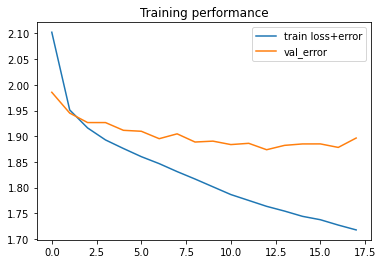

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

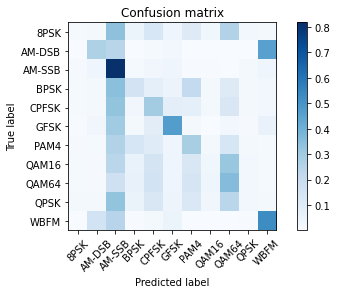

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09497882637628555


Overall Accuracy:  0.08970099667774087


Overall Accuracy:  0.09576703692584809


Overall Accuracy:  0.11194253217599522


Overall Accuracy:  0.11818993748139327


Overall Accuracy:  0.14159561510353227


Overall Accuracy:  0.18874773139745918


Overall Accuracy:  0.2725615314494075


Overall Accuracy:  0.30027132951462165


Overall Accuracy:  0.3767498478393183


Overall Accuracy:  0.3684210526315789


Overall Accuracy:  0.40758579169175196


Overall Accuracy:  0.4065015479876161


Overall Accuracy:  0.4250229990800368


Overall Accuracy:  0.3966205837173579


Overall Accuracy:  0.40931076178960096


Overall Accuracy:  0.4291350531107739


Overall Accuracy:  0.41369047619047616


Overall Accuracy:  0.4091318714328627


Overall Accuracy:  0.411836485661989


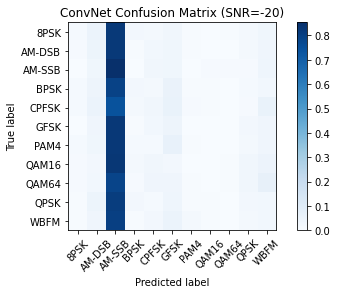

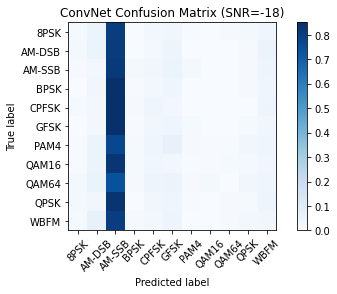

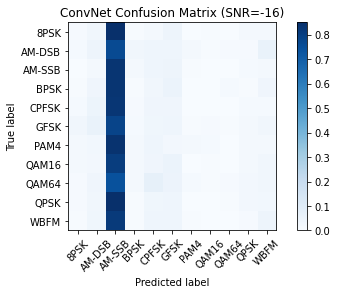

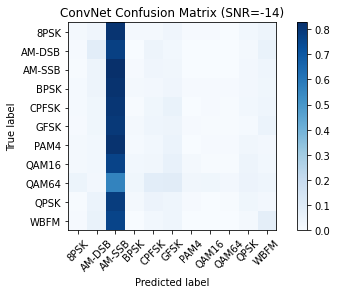

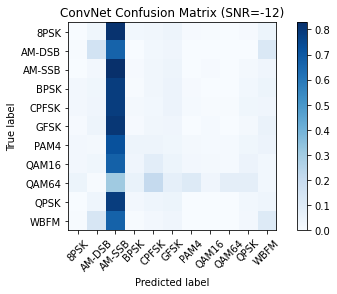

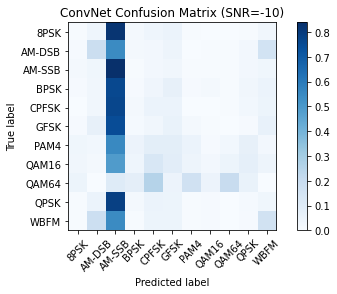

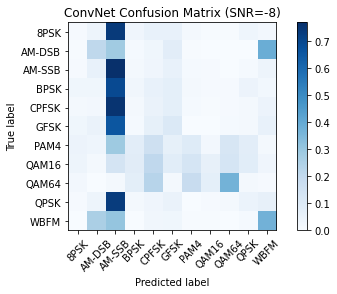

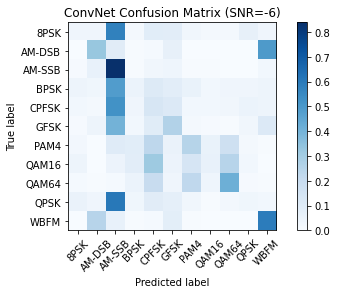

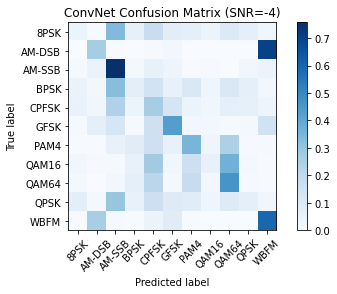

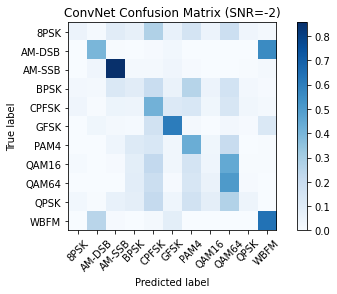

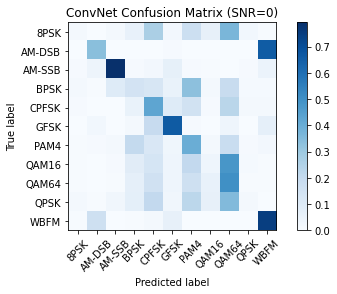

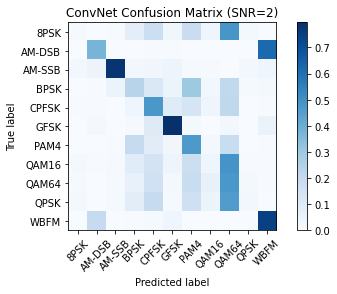

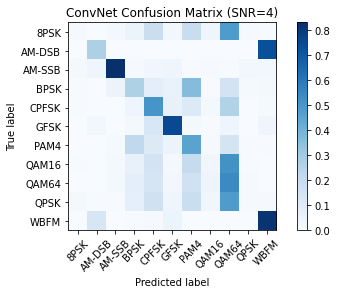

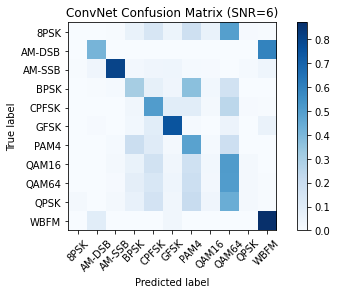

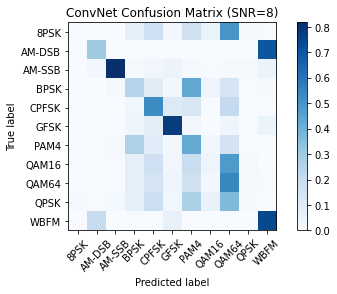

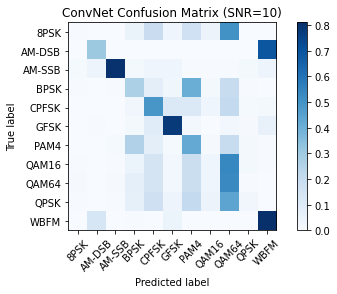

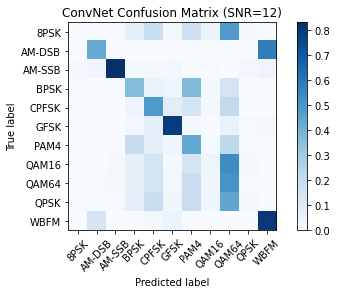

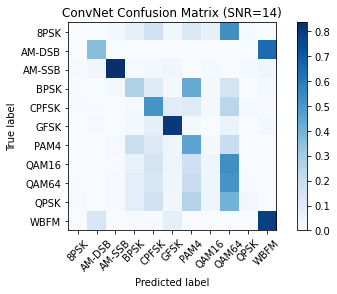

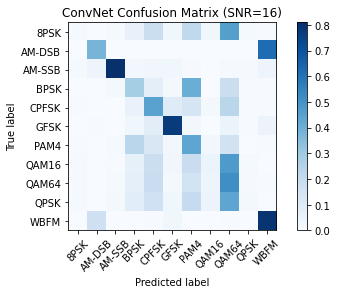

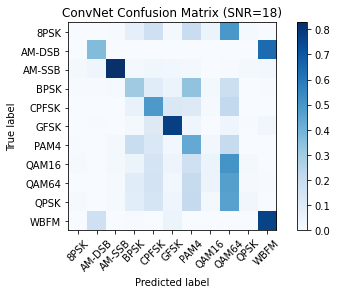

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,8,9,11,11,14,18,27,30,37,36,40,40,42,39,40,42,41,40,41


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

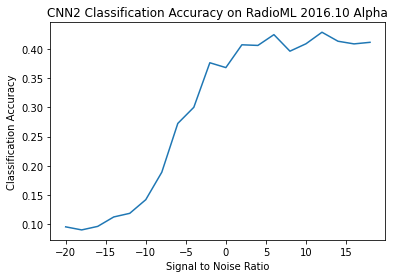

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")